# Data cleaning and feature engineering

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.color_palette("Paired")
sns.set_palette('muted')  
from scipy.stats import chi2_contingency
import statsmodels.api

# afficher seulement les minutes et secondes
import matplotlib.dates as md
from matplotlib.dates import MinuteLocator
ms_form = md.DateFormatter('%M:%S')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

BEST_PLAYERS =['Kobe Bryant', 'LeBron James', 'Stephen Curry', 'Kevin Durant', 'Dwyane Wade', 'Dirk Nowitzki', 'Tim Duncan', "Shaquille O'Neal", "Steve Nash", "Kawhi Leonard", "James Harden", "Jason Kidd", "Allen Iverson", "Chris Webber", "Kevin Garnett", "Paul Pierce", "Giannis Antetokounmpo", "Jimmy Butler", "Russell Westbrook", "Dwight Howard"]

def drop_players(data):
    """ Detele players that are not part of the study
    Args: 
        data : DataFrame
    Returns:
        data : DataFrame
    """
    data = data[data.PLAYER1_NAME.isin(BEST_PLAYERS)]

    return data


def drop_actions(data):
    """ Delete actions that are not shots (rebounds, violations, fouls, timeouts, etc.)
    Args: 
        data : DataFrame
    Returns:
        data : DataFrame
    """
    data = data[data.EVENTMSGTYPE < 4]
    return data 

def drop_assists(data):
    """ Delete actions where PLAYER2 is not null, it reprensents the assiting player so it means the shot is made
    Args: 
        data : DataFrame
    Returns:
        data : DataFrame
    """
    data = data[data.PLAYER2_ID == 0]
    return data 

def drop_blocks(data):
    """ Delete actions where PLAYER3 is not null, it reprensents the blocking player so it means the shot is not made
    Args: 
        data : DataFrame
    Returns:
        data : DataFrame
    """
    data = data[data.PLAYER3_ID == 0]
    return data

def update_freethrow_outcome(data):
    """ Update the outcome of a free throw, checks if SCORE is updated. The score is updated only if the goal is made
    Args: 
        data : DataFrame
    Returns:
        data : DataFrame
    """      
    data.loc[(data.EVENTMSGTYPE==3) & (data.SCORE.isna()), 'EVENTMSGTYPE'] = 2  # MISSED
    data.loc[(data.EVENTMSGTYPE==3) & (data.SCORE.notna()), 'EVENTMSGTYPE'] = 1 # MADE
    return data

def create_3pt_feature(data):
    data.loc[(data.HOMEDESCRIPTION.str.contains('3PT')) | (data.VISITORDESCRIPTION.str.contains('3PT')), '3PT'] = 1
    data.loc[data['3PT'].isna(), '3PT'] = 0
    return data

def create_jumpshot_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Jump Shot')) | (data.VISITORDESCRIPTION.str.contains('Jump Shot')), 'jump_shot'] = 1
    data.loc[data['jump_shot'].isna(), 'jump_shot'] = 0
    return data

def create_layup_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Layup')) | (data.VISITORDESCRIPTION.str.contains('Layup')), 'layup_shot'] = 1
    data.loc[data['layup_shot'].isna(), 'layup_shot'] = 0
    return data

def create_dunk_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Dunk')) | (data.VISITORDESCRIPTION.str.contains('Dunk')), 'dunk_shot'] = 1
    data.loc[data['dunk_shot'].isna(), 'dunk_shot'] = 0
    return data

def create_hook_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Hook')) | (data.VISITORDESCRIPTION.str.contains('Hook')), 'hook_shot'] = 1
    data.loc[data['hook_shot'].isna(), 'hook_shot'] = 0
    return data

def create_freethrow_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Free Throw')) | (data.VISITORDESCRIPTION.str.contains('Free Throw')), 'free_throw'] = 1
    data.loc[data['free_throw'].isna(), 'free_throw'] = 0
    return data

In [68]:
def clean_data(data):
    # Change index
    data = data.set_index(['GAME_ID', 'EVENTNUM'])

    data.loc[data.HOMEDESCRIPTION.isna(), 'HOMEDESCRIPTION'] = ''
    data.loc[data.VISITORDESCRIPTION.isna(), 'VISITORDESCRIPTION'] = ''

    data = drop_players(data)
    data = drop_actions(data)
    data = drop_assists(data)
    data = drop_blocks(data)
    data = update_freethrow_outcome(data)
    
    # Transform EVENTMSGTYPE to have 0 = MISSED and 1 = MADE
    data.loc[data.EVENTMSGTYPE==2, 'EVENTMSGTYPE'] = 0
    
    # Create features from HOMEDESCRIPTION and VISITORDESCRIPTION
    data = create_3pt_feature(data)
    data = create_jumpshot_feature(data)
    data = create_layup_feature(data)
    data = create_dunk_feature(data)
    data = create_hook_feature(data)
    data = create_freethrow_feature(data)
    
    # Drop columns
    data = data.drop(['HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', \
                    'PLAYER2_TEAM_CITY', 'PLAYER2_TEAM_ID', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_ID', 'PLAYER1_TEAM_CITY', 'PLAYER1_TEAM_ID','PLAYER2_TEAM_NICKNAME', \
                    'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', \
                    'SCOREMARGIN', 'VISITORDESCRIPTION', 'WCTIMESTRING', 'EVENTMSGACTIONTYPE'], axis = 1)

    # Transform PCTIMESTRING as time
    data.PCTIMESTRING = pd.to_datetime(data.PCTIMESTRING, format="%M:%S") 

    # Create features from PCTIMESTRING
    data['minutes_left'] = data['PCTIMESTRING'].dt.minute
    data['seconds_left'] = data['PCTIMESTRING'].dt.minute*60 + data['PCTIMESTRING'].dt.second
    data = data.drop('PCTIMESTRING', axis = 1)  

    return data

In [69]:
# Clean and concat all datasets
files = ['2000-01_pbp.csv','2001-02_pbp.csv','2002-03_pbp.csv','2003-04_pbp.csv','2004-05_pbp.csv',
         '2005-06_pbp.csv','2006-07_pbp.csv','2007-08_pbp.csv','2008-09_pbp.csv','2009-10_pbp.csv',
         '2010-11_pbp.csv','2011-12_pbp.csv','2012-13_pbp.csv','2013-14_pbp.csv','2014-15_pbp.csv',
         '2015-16_pbp.csv','2016-17_pbp.csv','2017-18_pbp.csv','2018-19_pbp.csv']

all_data = []

for file in files:
    data = pd.read_csv("../data/raw/"+file, index_col=0)
    all_data.append(clean_data(data))
    

plays = pd.concat(all_data)

# mise en évidence de la variable cible
plays = plays.rename({'EVENTMSGTYPE': 'target'}, axis=1)


# isoler la variable cible
X = plays.drop('target', axis=1)
y = plays.target

In [70]:
plays

target  PERIOD  PERSON1TYPE   PLAYER1_NAME  \
GAME_ID  EVENTNUM                                               
20001116 2              1       1          5.0  Allen Iverson   
         19             1       1          5.0  Allen Iverson   
         34             1       1          5.0  Allen Iverson   
         43             0       1          5.0  Allen Iverson   
         83             0       1          5.0  Allen Iverson   
...                   ...     ...          ...            ...   
21801037 537            0       4          4.0  Dirk Nowitzki   
         548            0       4          4.0  Dirk Nowitzki   
         589            0       4          4.0  Dirk Nowitzki   
         608            0       4          4.0  Dirk Nowitzki   
         612            0       4          4.0  Dirk Nowitzki   

                  PLAYER1_TEAM_NICKNAME  3PT  jump_shot  layup_shot  \
GAME_ID  EVENTNUM                                                     
20001116 2                        76ers  0.0        1.0         0.0   
         19                       76ers  0.0        0.0         1.0   
         34                       76ers  0.0        1.0         0.0   
         43                       76ers  0.0        1.0         0.0   
         83                       76ers  1.0        1.0         0.0   
...                                 ...  ...        ...         ...   
21801037 537                  Mavericks  1.0        1.0         0.0   
         548                  Mavericks  0.0        0.0         0.0   
         589                  Mavericks  0.0        1.0         0.0   
         608                  Mavericks  0.0        1.0         0.0   
         612                  Mavericks  0.0        0.0         0.0   

                   dunk_shot  hook_shot  free_throw  minutes_left  \
GAME_ID  EVENTNUM                                                   
20001116 2               0.0        0.0         0.0            11   
         19              0.0        0.0         0.0             9   
         34              0.0        0.0         0.0             7   
         43              0.0        0.0         0.0             5   
         83              0.0        0.0         0.0             0   
...                      ...        ...         ...           ...   
21801037 537             0.0        0.0         0.0             5   
         548             0.0        0.0         0.0             5   
         589             0.0        0.0         0.0             2   
         608             0.0        0.0         0.0             1   
         612             0.0        0.0         0.0             0   

                   seconds_left  
GAME_ID  EVENTNUM                
20001116 2                  705  
         19                 585  
         34                 461  
         43                 351  
         83                  28  
...                         ...  
21801037 537                350  
         548                321  
         589                146  
         608                 76  
         612                 46  

[311729 rows x 13 columns]

## Data Visualization

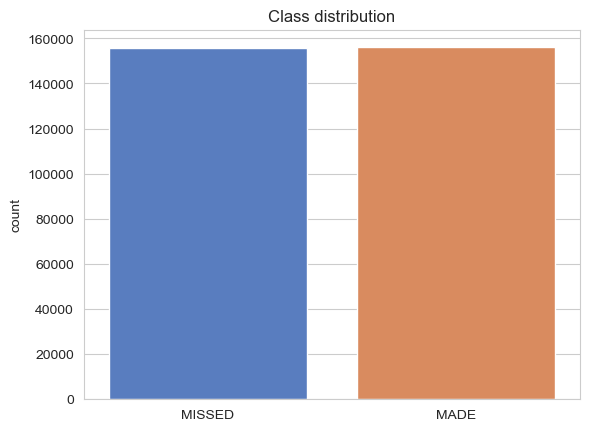

In [71]:
# Check class distribution
sns.countplot(data=plays, x='target')
plt.title("Class distribution")
plt.xticks([0,1], labels=['MISSED', 'MADE'])
plt.xlabel('')
plt.show()

The classes are balanced

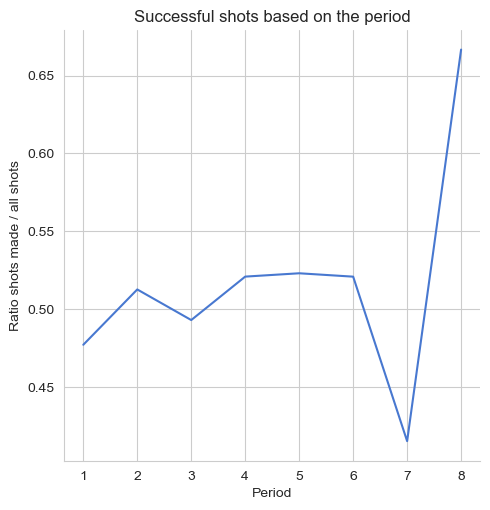

In [72]:
reussis = plays[plays.target==1].groupby(['PERIOD'])['target'].agg('count')
rates = plays[plays.target==0].groupby(['PERIOD'])['target'].agg('count')
moyenne = plays[plays.target==1].groupby(['PERIOD']).agg('count')
moyenne['RATIO']= reussis / (rates+reussis)

sns.relplot(moyenne, x='PERIOD', y='RATIO', kind='line')
plt.title("Successful shots based on the period")
plt.xlabel("Period")
plt.ylabel("Ratio shots made / all shots")
plt.show()

Success seems to increase over time

In [73]:
# Correlation test target vs period
ct = pd.crosstab(plays.target, plays.PERIOD)
res = chi2_contingency(ct)
print("Test statistic =", res[0])
print("p-value =", res[1])

print("The p-value is less than 5%, so we can conclude that the is not independent of the period.")

Test statistic = 367.4846700010747
p-value = 2.221168886126626e-75
The p-value is less than 5%, so we can conclude that the is not independent of the period.


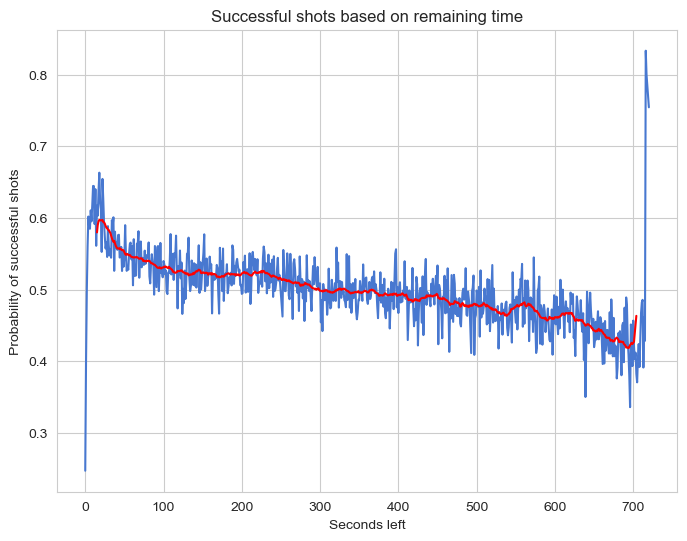

In [74]:
reussis = plays[plays.target==1].groupby(['seconds_left'])['target'].agg('count')
rates = plays[plays.target==0].groupby(['seconds_left'])['target'].agg('count')
moyenne = plays[plays.target==1].groupby(['seconds_left']).agg('count')
moyenne['RATIO']= reussis / (rates+reussis)

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(moyenne, x='seconds_left', y='RATIO', ax=ax)
plt.title("Successful shots based on remaining time")
plt.xlabel("Seconds left")
plt.ylabel("Probability of successful shots")

mean = moyenne['RATIO'].rolling(window=30, center=True).mean()
plt.plot(mean, color="red")

plt.show()

In [75]:
# Test correlation with ANOVA
result = statsmodels.formula.api.ols('seconds_left ~ target', data=plays).fit()
statsmodels.api.stats.anova_lm(result)

,df,sum_sq,mean_sq,F,PR(>F)
target,1.0,4.555232e+07,4.555232e+07,1092.81069,3.141836e-239
Residual,311727.0,1.299391e+10,4.168363e+04,NaN,NaN


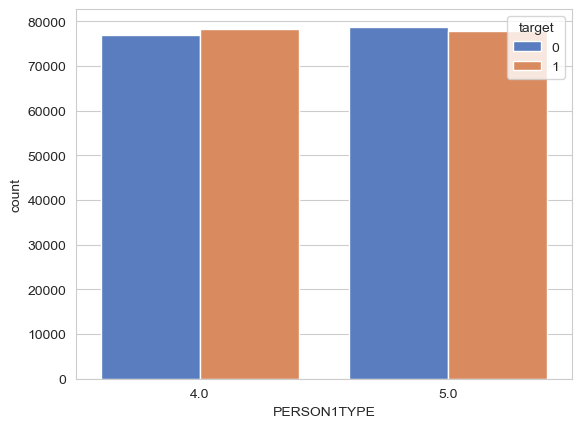

In [76]:
sns.countplot(data=plays, x='PERSON1TYPE', hue='target')
plt.show()

In [77]:
# Correlation test target vs person1type
ct = pd.crosstab(plays.target, plays.PERSON1TYPE)
res = chi2_contingency(ct)
print("Statistique du test =", res[0])
print("p-valeur =", res[1])

print("The p-value is less than 5%, so we can conclude that target is not independent of the person1type variable.")

Statistique du test = 18.64240483683667
p-valeur = 1.5767414782354195e-05
The p-value is less than 5%, so we can conclude that target is not independent of the person1type variable.


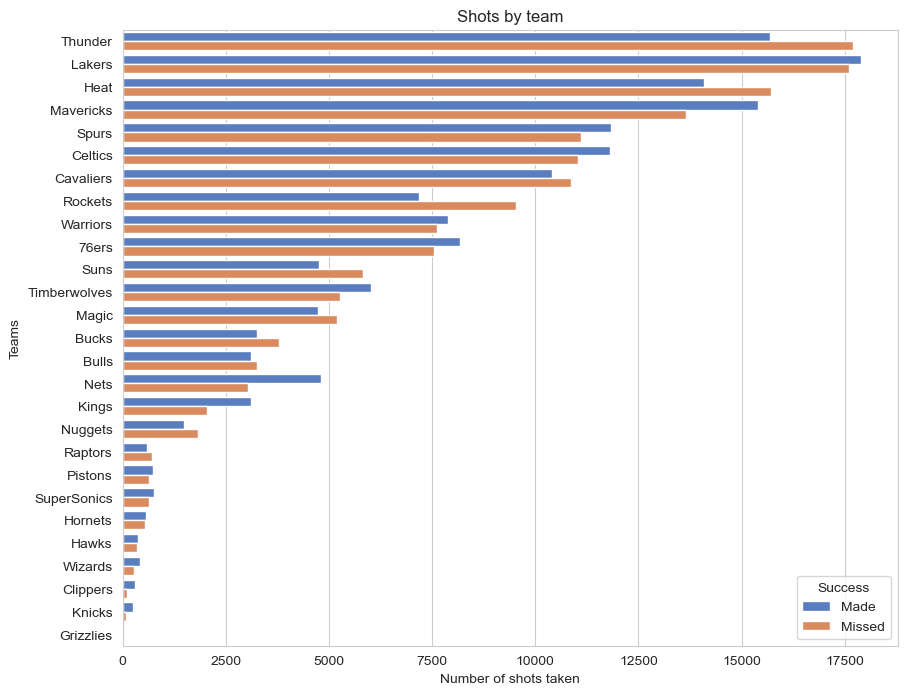

In [78]:
# success by team
plt.figure(figsize=(10,8))

plot = sns.countplot(data=plays, 
                     y='PLAYER1_TEAM_NICKNAME', 
                     hue='target', 
                     order=plays[plays.target==1]['PLAYER1_TEAM_NICKNAME'].value_counts().index)
plt.title('Shots by team')
plt.ylabel('Teams')
plt.xlabel('Number of shots taken')

# Légende 
leg = plot.axes.get_legend()
leg.set_title('Success')
new_labels = ['Made', 'Missed']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

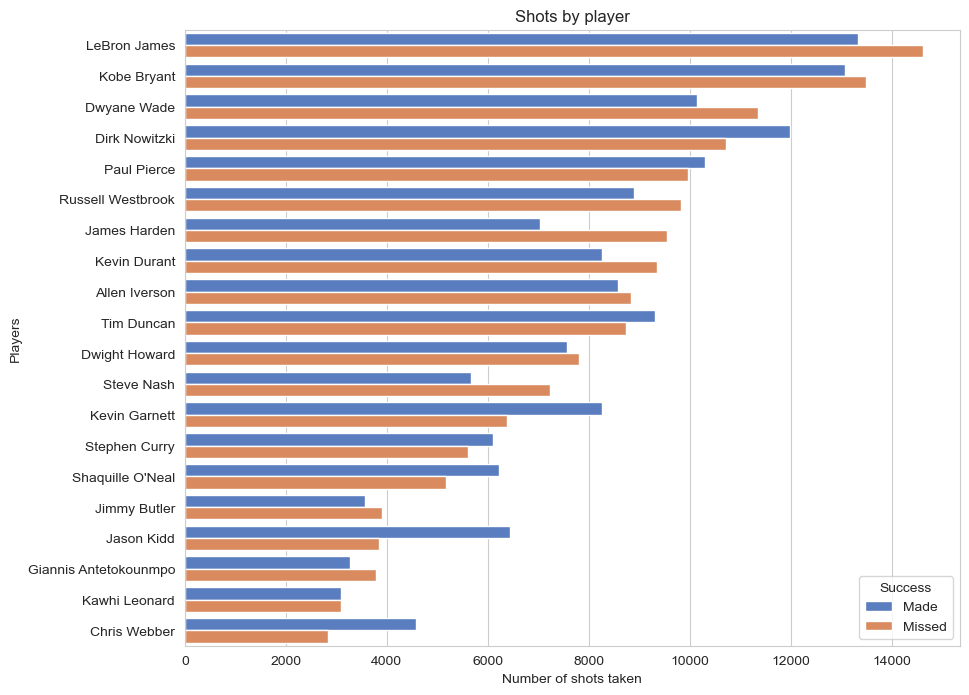

In [79]:
# success by player
plt.figure(figsize=(10,8))

plot = sns.countplot(data=plays, 
                     y='PLAYER1_NAME', 
                     hue='target', 
                     order=plays[plays.target==1]['PLAYER1_NAME'].value_counts().index)
plt.title('Shots by player')
plt.ylabel('Players')
plt.xlabel('Number of shots taken')

# Légende 
leg = plot.axes.get_legend()
leg.set_title('Success')
new_labels = ['Made', 'Missed']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

# Predictions

In [80]:
# prepare data for modeling
df = pd.get_dummies(plays)

X = df.drop('target', axis = 1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# réduction de dimensions
sel = SelectKBest(score_func = chi2)
sel.fit(X_train, y_train)
mask = sel.get_support()

X_train_sel = sel.transform(X_train)
X_test_sel = sel.transform(X_test)

In [81]:
# Random Forest
rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)

print('Accuracy with RandomForest:', accuracy_score(y_test, y_pred))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Accuracy with RandomForest: 0.6522631764668142


Classe prédite,0,1
Classe réelle,,
0,20286,10881
1,10799,20380


In [82]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=.1, objective='binary:logistic')

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print('Accuracy with XGBoost:', accuracy_score(y_test, y_pred))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Accuracy with XGBoost: 0.7272479389215026


Classe prédite,0,1
Classe réelle,,
0,21938,9229
1,7776,23403
